<a href="https://colab.research.google.com/github/moo-337/moo/blob/master/docs/get_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

In [2]:
mu, sig, beta, n, K = 4, 0.25, 0.99, 10, 40 

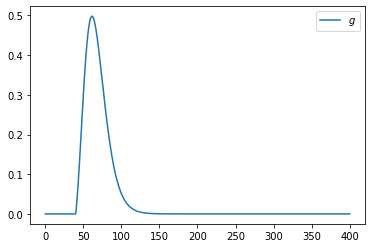

In [3]:
from scipy.stats import lognorm

def f(x):
    return lognorm.pdf(x, sig, scale=np.exp(mu))

def g(x):
    return np.maximum(x - K, 0) * f(x)

x_grid = np.linspace(0, 400, 1_000)
y_grid = g(x_grid)

fig, ax = plt.subplots()
ax.plot(x_grid, y_grid, label="$g$")
ax.legend()
plt.show()


In [4]:
from scipy.integrate import quad

integral, error = quad(g, 0, 1_000)
P = beta**n * integral
print(f"The numerical integration based option price is {P:.3f}")

The numerical integration based option price is 15.188


In [5]:
M = 10_000_000
S = np.exp(mu + sig * np.random.randn(M))
payoffs = np.maximum(S - K, 0)
P = beta ** n * payoffs.mean()
print(f"The Monte Carlo option price is {P:.3f}")

The Monte Carlo option price is 15.185


In [6]:
Model = namedtuple("Model", ("beta", "mu", "K", "cpn", "B", "n", "rho", "v", "S0", "h0"))

In [40]:
def create_model_autocall(beta=1., 
                 mu=0.00001,
                 K=[0.9, 0.85, 0.8, 0.75, 0.7, 0.7],
                 cpn=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
                 B=0.45,
                 n=1000,
                 rho=0.1,
                 v=0.01,
                 S0=1,
                 h0=0):
    return Model(beta=beta, mu=mu, K=K, cpn=cpn, B=B, n=n, rho=rho, v=v, S0=S0, h0=h0)

In [41]:
default_model = create_model_autocall()

In [35]:
from numpy.random import randn

def simulate_asset_price_path(model):

    beta, mu, K, cpn, B, n, rho, v, S0, h0 = model
    s = np.empty(n+1)
    s[0] = np.log(S0)

    h = h0
    for t in range(n):
        s[t+1] = s[t] + mu + h * randn()
        h = rho * h + v * randn()

    return np.exp(s)

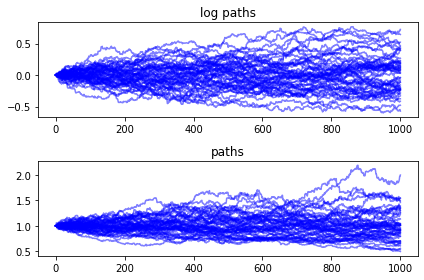

In [42]:
fig, axes = plt.subplots(2, 1)

titles = 'log paths', 'paths'
transforms = np.log, lambda x: x
for ax, transform, title in zip(axes, transforms, titles):
    for i in range(50):
        path = simulate_asset_price_path(default_model)
        ax.plot(transform(path), 'b-', alpha=0.5)
    ax.set_title(title)

fig.tight_layout()
plt.show()


In [48]:
from numba import njit
# pip install --upgrade numda
default_M = 200_000

In [49]:
@njit
def compute_Autocall_price(model, M=default_M):

    beta, mu, K, cpn, B, n, rho, v, S0, h0 = model
    current_sum = 0.0

    early_call_n = len(K)
    early_call_idx = [(i+1)*(n//early_call_n) for i in range(early_call_n-1)]

    for m in range(M):
        s = np.log(S0)
        h = h0
        early_date_cnt = 0
        barrier_flag = False
        early_call_flag = False
        for t in range(n):

            s = s + mu + h * randn()
            h = rho * h + v * randn()
            exp_s = np.exp(s)

            if t == early_call_idx[early_date_cnt]:
                if exp_s < S0*K[early_date_cnt]:
                    if early_call_n-2 != early_date_cnt:
                        early_date_cnt +=1
                    continue
                if exp_s >= S0*K[early_date_cnt]:
                    early_call_flag = True
                    current_sum += beta**t * (1 + cpn[early_date_cnt])
                    break
            if exp_s <= S0*B:
                barrier_flag = True
        
        if not barrier_flag and not early_call_flag:
            current_sum += beta**n * (1 + cpn[-1])
        
        if barrier_flag and not early_call_flag:
            if exp_s >= S0*K[-1]:
                current_sum += beta**t * (1 + cpn[early_date_cnt])
            if exp_s < S0*K[-1]:                
                current_sum += beta**n * exp_s / S0

    return current_sum / M

In [50]:
%%time
compute_Autocall_price(default_model)

KeyboardInterrupt: ignored

In [16]:
%%time
compute_call_price(default_model)

NameError: ignored

In [17]:
from numba import prange

In [18]:
@njit(parallel=True)
def compute_call_price_parallel(model, M=default_M):

    beta, mu, K, n, rho, v, S0, h0 = model

    current_sum = 0.0
    for m in prange(M):
        s = np.log(S0)
        h = h0
        for t in range(n):
            s = s + mu + np.exp(h) * randn()
            h = rho * h + v * randn()

        current_sum += np.maximum(np.exp(s) - K, 0)

    return beta**n * current_sum / M


In [19]:
%%time
compute_call_price_parallel(default_model)

TypingError: ignored

In [20]:
%%time
compute_call_price_parallel(default_model)

TypingError: ignored

In [21]:
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

find: ‘/proc/57/task/57/net’: Invalid argument
find: ‘/proc/57/net’: Invalid argument
/usr/local/lib/python3.9/dist-packages/jaxlib/cuda/nvvm/libdevice
/usr/local/cuda-11.8/nvvm/libdevice
find: ‘/proc/57/task/57/net’: Invalid argument
find: ‘/proc/57/net’: Invalid argument
/usr/local/cuda-11.8/nvvm/lib64/libnvvm.so


In [22]:
from math import log, exp
from numba import cuda, objmode, float32, int32
from numba.cuda.random import xoroshiro128p_normal_float32 as xnf32
from numba.cuda.random import create_xoroshiro128p_states as x128_states

In [23]:
def convert_to_32_bit(scalar):
    if isinstance(scalar, float):
        return float32(scalar)
    return(int32(scalar))

In [24]:
@cuda.jit(device=True)
def update_price(params, s, h, zeta_1, zeta_2):
    beta, mu, K, n, rho, v = params
    s = s + mu + exp(h) * zeta_1
    h = rho * h + v * zeta_2
    return s, h

In [25]:
@cuda.jit
def price_generation_kernel(params, init_vals, price_sample, rng_states):

    pos = cuda.grid(1)
    beta, mu, K, n, rho, v = params
    S0, h0 = init_vals

    s, h = log(S0), h0

    for t in range(n):

        zeta_1 = xnf32(rng_states, pos)
        zeta_2 = xnf32(rng_states, pos)
        s, h = update_price(params, s, h, zeta_1, zeta_2)
    
    price_sample[pos] = exp(s)


In [26]:
def compute_call_price_cuda(model,
                            M=default_M,
                            seed=1234,
                            threads_per_block=132):
    
    nthreads = threads_per_block
    nblocks = M // nthreads
    beta, mu, K, n, rho, v, S0, h0 = model
    params = tuple(map(convert_to_32_bit, (beta, mu, K, n, rho, v)))
    init_vals = tuple(map(convert_to_32_bit, (S0, h0)))

    rng_states = x128_states(M, seed=seed)

    price_sample = cuda.to_device(np.zeros(M))

    price_generation_kernel[nblocks, nthreads](
        params, init_vals, price_sample, rng_states
    )

    price_sample = price_sample.copy_to_host()
    payoffs = np.maximum(price_sample - K, 0)
    return beta**n * np.mean(payoffs)

In [27]:
%%time
compute_call_price_cuda(default_model)

ValueError: ignored

In [28]:
%%time
compute_call_price_cuda(default_model)

ValueError: ignored

In [29]:
import jax
import jax.numpy as jnp

In [30]:
def compute_call_price_jax(model=default_model, 
                           M=default_M,
                           key=jax.random.PRNGKey(1)):
    
    beta, mu, K, n, rho, v, S0, h0 = model

    s = jnp.full(M, jnp.log(S0))
    h = jnp.full(M, h0)
    for t in range(n):
        key, subkey = jax.random.split(key)
        Z = jax.random.normal(subkey, (2, M))
        s = s + mu + jnp.exp(h) * Z[0, :]
        h = rho * h + v * Z[1, :]
    expectation = jnp.mean(jnp.maximum(jnp.exp(s) - K, 0))

    return beta ** n * expectation

In [31]:
%%time
compute_call_price_jax().block_until_ready()

ValueError: ignored

In [32]:
%%time
compute_call_price_jax().block_until_ready()

ValueError: ignored

In [33]:
compute_call_price_jax_jit = jax.jit(compute_call_price_jax)

In [34]:
%%time
compute_call_price_jax_jit().block_until_ready()

ValueError: ignored

In [35]:
%%time
compute_call_price_jax_jit().block_until_ready()

ValueError: ignored